In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

In [2]:
df = pd.read_csv(r"C:\Users\Shaz\Downloads\AGCensusPrediction\data\cleaned_COUNTY_data.csv")
print(f"Data shape: {df.shape}")
print(f"Years: {sorted(df['YEAR'].unique())}")
print(f"Counties: {df['COUNTY_NAME'].nunique()}")

Data shape: (762, 2178)
Years: [np.int64(2012), np.int64(2017), np.int64(2022)]
Counties: 254


In [3]:
production_cols = [col for col in df.columns if 'PRODUCTION' in col]

print(f"Production Columns: {len(production_cols)}")

hay_cols = [col for col in production_cols if 'HAY' in col] 

print(f"Hay Columns: {len(hay_cols)}")
for i, col in enumerate(hay_cols,1):
    print(f"{i:2d}. {col}")
    
print(f"\n Hay production variables: {len(hay_cols)}")

Production Columns: 152
Hay Columns: 10
 1. HAYHAYLAGE_HAYHAYLAGEPRODUCTIONMEASUREDINTONSDRYBASIS
 2. HAYLAGE_HAYLAGEALFALFAPRODUCTIONMEASUREDINTONS
 3. HAYLAGE_HAYLAGEEXCLALFALFAPRODUCTIONMEASUREDINTONS
 4. HAYLAGE_HAYLAGEPRODUCTIONMEASUREDINTONS
 5. HAY_HAYALFALFAPRODUCTIONMEASUREDINTONS
 6. HAY_HAYEXCLALFALFAPRODUCTIONMEASUREDINTONS
 7. HAY_HAYPRODUCTIONMEASUREDINTONS
 8. HAY_HAYSMALLGRAINPRODUCTIONMEASUREDINTONS
 9. HAY_HAYTAMEEXCLALFALFASMALLGRAINPRODUCTIONMEASUREDINTONS
10. HAY_HAYWILDPRODUCTIONMEASUREDINTONS

 Hay production variables: 10


In [4]:
# Hay production model
hay_results = {}

for target_col in hay_cols:
    print(f"\nTraining model for target: {target_col}")
    
    display_name = target_col.replace('PRODUCTION', '').replace('MEASURED IN', ' ').strip()
    print(f"\n{display_name}")
    
    data = df[[target_col, 'YEAR']].copy()
    data = data.dropna(subset=[target_col])
    
    if len(data) < 30:
        print(f"Insufficient data (need ≥30)")
        continue
    
    x = data[['YEAR']].values
    y = data[target_col].values
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_r2 = r2_score(y_test, lr.predict(X_test))
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
    
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_r2 = r2_score(y_test, rf.predict(X_test))    
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
    
    best_r2 = max(lr_r2, rf_r2)
    best_model = lr if lr_r2 >= rf_r2 else rf
    
    x_2027 = np.array([[2027]])
    pred_2027 = best_model.predict(x_2027)[0]
    histo_avg = y_train.mean()
    growth_rate = ((pred_2027 - histo_avg) / histo_avg) * 100
    hay_results[display_name] = {
        'target_col': target_col,
        'data_points': len(data),
        'lr_r2': lr_r2,
        'rf_r2': rf_r2,
        'best_r2': best_r2,
        'best_model': 'RF' if rf_r2 > lr_r2 else 'LR',
        'lr_rmse': lr_rmse,
        'rf_rmse': rf_rmse,
        'historical_avg': histo_avg,
        'forecast_2027': pred_2027,
        'growth_rate': growth_rate,
        'lr_obj': lr,
        'rf_obj': rf
    }
    
    print(f"  LR R²: {lr_r2:.4f} | RMSE: {lr_rmse:,.0f}")
    print(f"  RF R²: {rf_r2:.4f} | RMSE: {rf_rmse:,.0f}")
    print(f"  Best: {hay_results[display_name]['best_model']} (R² = {best_r2:.4f})")


Training model for target: HAYHAYLAGE_HAYHAYLAGEPRODUCTIONMEASUREDINTONSDRYBASIS

HAYHAYLAGE_HAYHAYLAGEMEASUREDINTONSDRYBASIS
  LR R²: -0.0199 | RMSE: 40,073
  RF R²: -0.0224 | RMSE: 40,122
  Best: LR (R² = -0.0199)

Training model for target: HAYLAGE_HAYLAGEALFALFAPRODUCTIONMEASUREDINTONS

HAYLAGE_HAYLAGEALFALFAMEASUREDINTONS
  LR R²: -0.0549 | RMSE: 7,335
  RF R²: -0.0624 | RMSE: 7,361
  Best: LR (R² = -0.0549)

Training model for target: HAYLAGE_HAYLAGEEXCLALFALFAPRODUCTIONMEASUREDINTONS

HAYLAGE_HAYLAGEEXCLALFALFAMEASUREDINTONS
  LR R²: -0.0339 | RMSE: 18,324
  RF R²: -0.0340 | RMSE: 18,324
  Best: LR (R² = -0.0339)

Training model for target: HAYLAGE_HAYLAGEPRODUCTIONMEASUREDINTONS

HAYLAGE_HAYLAGEMEASUREDINTONS
  LR R²: -0.0871 | RMSE: 9,639
  RF R²: -0.0912 | RMSE: 9,657
  Best: LR (R² = -0.0871)

Training model for target: HAY_HAYALFALFAPRODUCTIONMEASUREDINTONS

HAY_HAYALFALFAMEASUREDINTONS
  LR R²: -0.0113 | RMSE: 5,930
  RF R²: -0.0139 | RMSE: 5,937
  Best: LR (R² = -0.0113)

In [5]:
print("\n" + "="*80)
print("HAY PRODUCTION FORECAST SUMMARY (2027)")
print("="*80 + "\n")

# Sort by R² score
sorted_by_r2 = sorted(
    hay_results.items(),
    key=lambda x: x[1]['best_r2'],
    reverse=True
)

print(f"{'Hay Type':<45} {'R²':<8} {'Points':<8} {'2027 Growth':<12}")
print("-" * 80)

summary_data = []
for name, results in sorted_by_r2:
    print(f"{name[:44]:<45} {results['best_r2']:<8.4f} {results['data_points']:<8} {results['growth_rate']:<+12.1f}%")
    
    summary_data.append({
        'Hay_Type': name,
        'Data_Points': results['data_points'],
        'LR_R2': f"{results['lr_r2']:.4f}",
        'RF_R2': f"{results['rf_r2']:.4f}",
        'Best_Model': results['best_model'],
        'Best_R2': f"{results['best_r2']:.4f}",
        'LR_RMSE': f"{results['lr_rmse']:,.0f}",
        'RF_RMSE': f"{results['rf_rmse']:,.0f}",
        'Historical_Avg_Tons': f"{results['historical_avg']:,.0f}",
        'Forecast_2027_Tons': f"{results['forecast_2027']:,.0f}",
        'Growth_Rate_%': f"{results['growth_rate']:+.1f}%"
    })



HAY PRODUCTION FORECAST SUMMARY (2027)

Hay Type                                      R²       Points   2027 Growth 
--------------------------------------------------------------------------------
HAY_HAYWILDMEASUREDINTONS                     -0.0035  477      -2.2        %
HAY_HAYSMALLGRAINMEASUREDINTONS               -0.0081  552      -1.5        %
HAY_HAYALFALFAMEASUREDINTONS                  -0.0113  594      -47.4       %
HAY_HAYTAMEEXCLALFALFASMALLGRAINMEASUREDINTO  -0.0144  678      +1.7        %
HAY_HAYEXCLALFALFAMEASUREDINTONS              -0.0147  684      -10.0       %
HAY_HAYMEASUREDINTONS                         -0.0166  750      -20.4       %
HAYHAYLAGE_HAYHAYLAGEMEASUREDINTONSDRYBASIS   -0.0199  750      -15.5       %
HAYLAGE_HAYLAGEEXCLALFALFAMEASUREDINTONS      -0.0339  642      +46.2       %
HAYLAGE_HAYLAGEALFALFAMEASUREDINTONS          -0.0549  249      -48.0       %
HAYLAGE_HAYLAGEMEASUREDINTONS                 -0.0871  660      +39.4       %


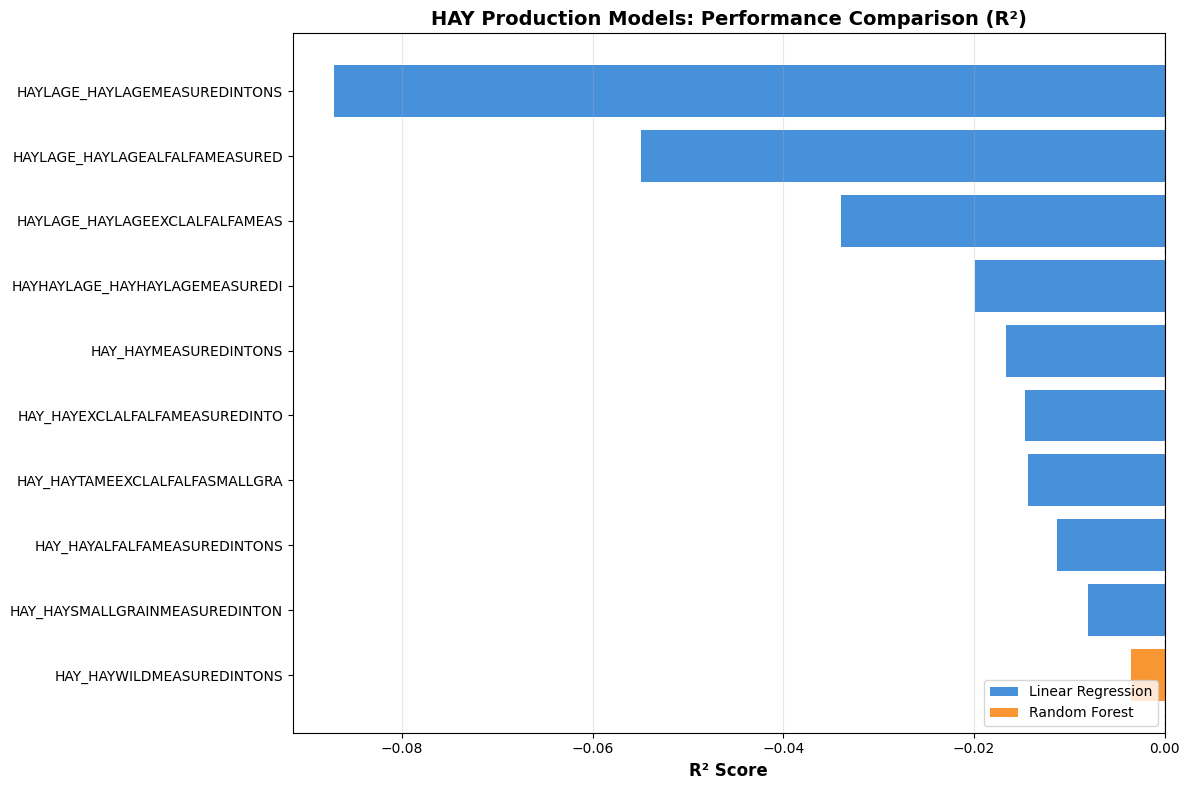

In [6]:
# Chart 1: Model Performance
fig, ax = plt.subplots(figsize=(12, 8))

hay_names = [name[:30] for name, _ in sorted_by_r2]
hay_r2 = [results['best_r2'] for _, results in sorted_by_r2]
hay_best_models = [results['best_model'] for _, results in sorted_by_r2]

colors = ['#1976D2' if model == 'LR' else '#F57C00' for model in hay_best_models]

bars = ax.barh(range(len(hay_names)), hay_r2, color=colors, alpha=0.8)

ax.set_yticks(range(len(hay_names)))
ax.set_yticklabels(hay_names)
ax.set_xlabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('HAY Production Models: Performance Comparison (R²)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#1976D2', alpha=0.8, label='Linear Regression'),
                   Patch(facecolor='#F57C00', alpha=0.8, label='Random Forest')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()

plt.show()

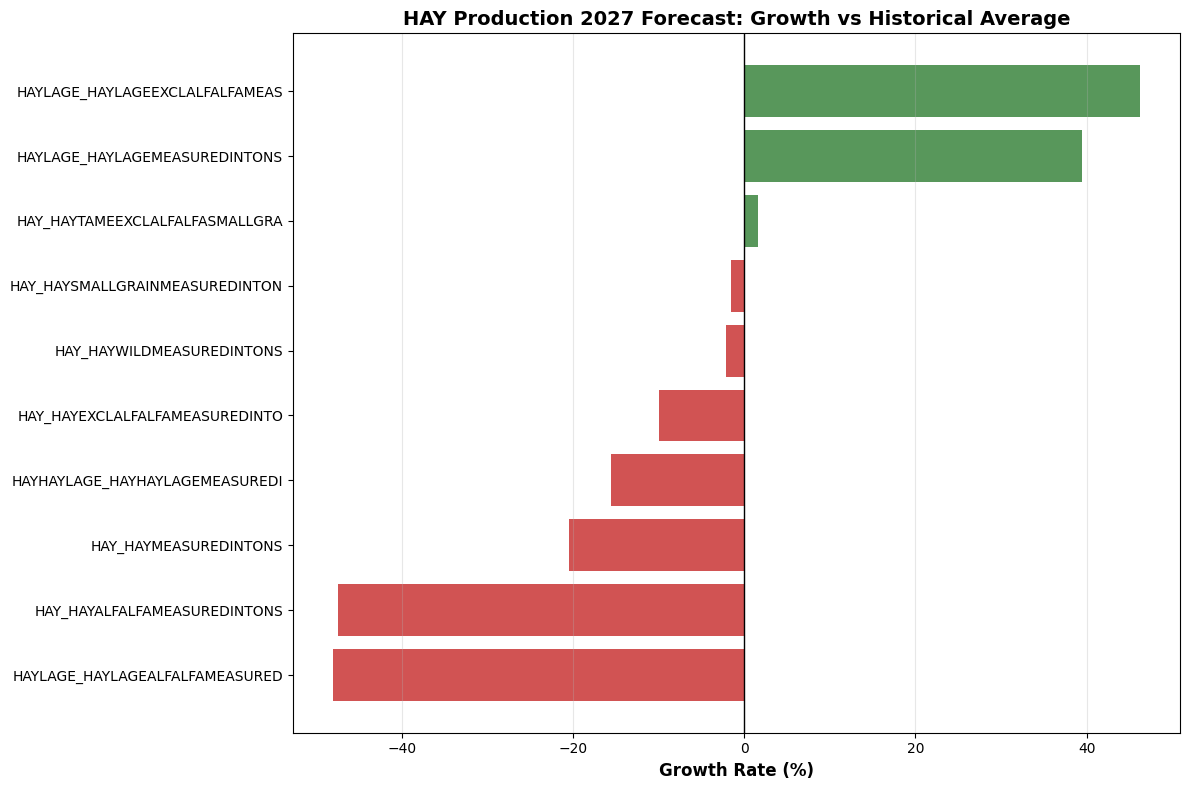

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

sorted_by_growth = sorted(
    hay_results.items(),
    key=lambda x: x[1]['growth_rate']
)

hay_names_growth = [name[:30] for name, _ in sorted_by_growth]
hay_growth = [results['growth_rate'] for _, results in sorted_by_growth]
colors_growth = ['#C62828' if g < 0 else '#2E7D32' for g in hay_growth]

bars = ax.barh(range(len(hay_names_growth)), hay_growth, color=colors_growth, alpha=0.8)

ax.set_yticks(range(len(hay_names_growth)))
ax.set_yticklabels(hay_names_growth)
ax.set_xlabel('Growth Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('HAY Production 2027 Forecast: Growth vs Historical Average', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()